In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.utils.data as data
from torchsummary import summary

In [2]:
NCLASSES = 43
BACTH_SIZE = 64
CLASSES = {
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons'
}

<ipython-input-55-c419e9eaa52f>:2: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(h_pad=20)


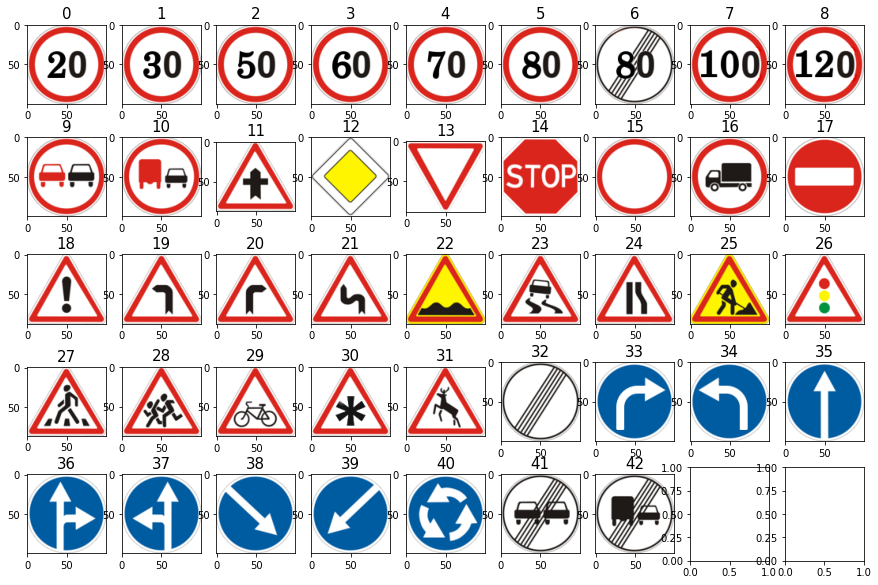

In [55]:
fig, axs = plt.subplots(5, 9, figsize=(15, 10))
fig.tight_layout(h_pad=20)
for i in range(NCLASSES):
    row = i // 9
    col = i % 9
    
    image_name = "data/Meta/{}.png".format(i)
    img = Image.open(image_name)
    axs[row, col].imshow(img)
    axs[row, col].set_title(str(i), fontsize=15)
    
plt.savefig("classes.png", bbox_inches="tight", pad_inches=0.5)

In [4]:
folders = os.listdir("data/train")
D = {}

for folder in folders:
    train_files = os.listdir("data/train/{}".format(folder))
    D[CLASSES[int(folder)]] = len(train_files)
    
# D.keys()

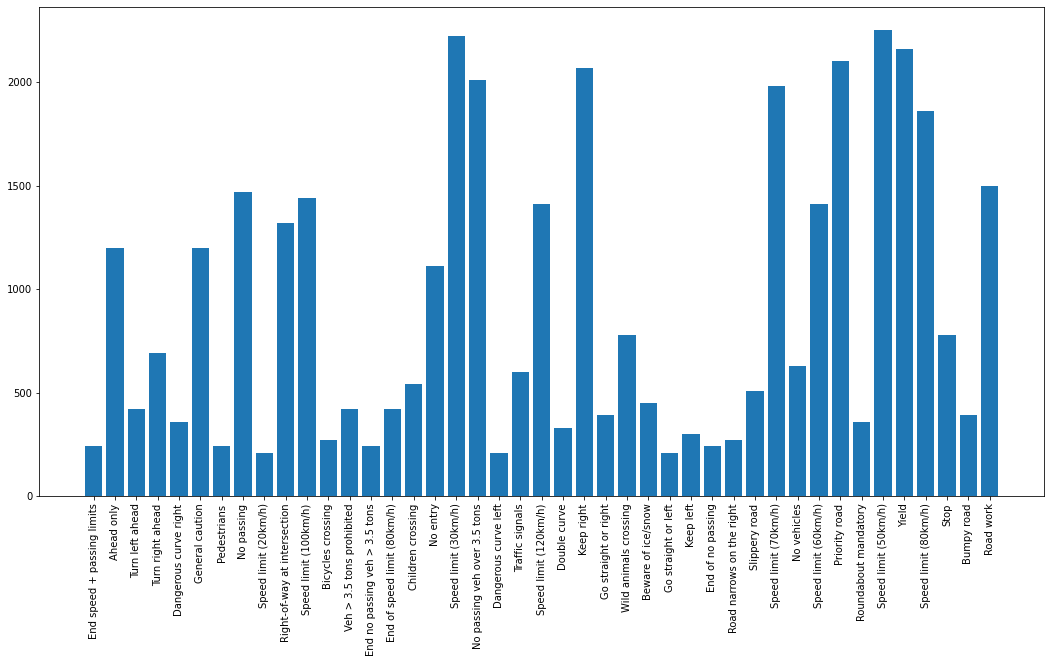

In [45]:
plt.figure(figsize=(18, 9))
plt.bar(D.keys(), D.values())
plt.xticks(list(D.keys()), rotation='vertical')
plt.show()

In [6]:
BATCH_SIZE = 256
learning_rate = 0.001
EPOCHS = 15

In [7]:
data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
])

# data_transforms = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
# ])

train_data_path = "data/Train"
train_data = datasets.ImageFolder(root = train_data_path, transform = data_transforms)

# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])

print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")

Number of training samples = 31367
Number of validation samples = 7842


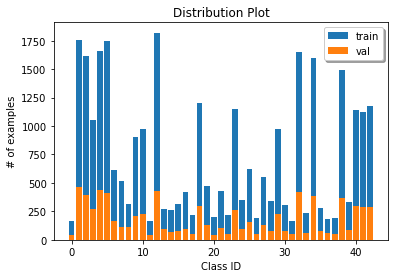

In [8]:
# Plot histogram for training and validation data

train_hist = [0]*NCLASSES
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1
    
val_hist = [0]*NCLASSES
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

plt.bar(range(NCLASSES), train_hist, label="train")
plt.bar(range(NCLASSES), val_hist, label="val")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.savefig("train_val_split.png", bbox_inches = 'tight', pad_inches=0.5)

In [8]:
train_loader = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE)

# test_loader =DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

torch.Size([256, 3, 112, 112])


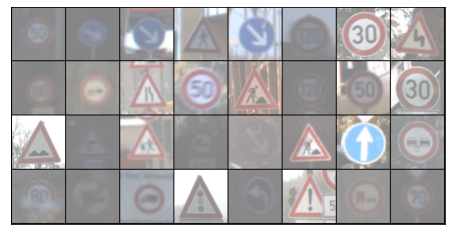

In [35]:
from torchvision.utils import make_grid, save_image
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=32):
    for images, _ in dl:
        show_images(images, nmax)
        break
        
show_batch(train_loader)

In [9]:
class Net(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, output_dim)
        )
        
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [10]:
class Net2(nn.Module):
    def __init__(self, nclasses=43):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, nclasses)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [10]:
model = Net(NCLASSES)
# model = Net2(43)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [11]:
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [14]:
print(summary(model, (3, 112, 112)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           1,792
         MaxPool2d-2           [-1, 64, 28, 28]               0
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 192, 28, 28]         110,784
         MaxPool2d-5          [-1, 192, 14, 14]               0
              ReLU-6          [-1, 192, 14, 14]               0
            Conv2d-7          [-1, 384, 14, 14]         663,936
              ReLU-8          [-1, 384, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]         884,992
             ReLU-10          [-1, 256, 14, 14]               0
           Conv2d-11          [-1, 256, 14, 14]         590,080
        MaxPool2d-12            [-1, 256, 7, 7]               0
             ReLU-13            [-1, 256, 7, 7]               0
          Dropout-14                [-1

/opt/homebrew/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [15]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [16]:
def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    for (images, labels) in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)
        
        opt.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        
        loss.backward()
        acc = calculate_accuracy(output, labels)
        
        opt.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [17]:
def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Evaluate the model
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in tqdm(loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Run predictions
            output = model(images)
            loss = criterion(output, labels)
            
            # Calculate accuracy
            acc = calculate_accuracy(output, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [19]:
EPOCHS = 5
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS


In [20]:
import time
for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()

    val_start_time = time.monotonic()
    val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion)
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc
    
    print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
    print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
    print("")

Epoch-0: 


100%|██████████| 31/31 [00:28<00:00,  1.10it/s]


Training: Loss = 2.4296, Accuracy = 0.2894, Time = 331.92 seconds
Validation: Loss = 1.3510, Accuracy = 0.5359, Time = 28.26 seconds

Epoch-1: 


100%|██████████| 31/31 [00:24<00:00,  1.24it/s]


Training: Loss = 0.9160, Accuracy = 0.6925, Time = 306.63 seconds
Validation: Loss = 0.3992, Accuracy = 0.8764, Time = 24.99 seconds

Epoch-2: 


100%|██████████| 31/31 [00:23<00:00,  1.29it/s]


Training: Loss = 0.3520, Accuracy = 0.8842, Time = 308.24 seconds
Validation: Loss = 0.1646, Accuracy = 0.9485, Time = 23.98 seconds

Epoch-3: 


100%|██████████| 31/31 [00:24<00:00,  1.29it/s]


Training: Loss = 0.1912, Accuracy = 0.9388, Time = 298.99 seconds
Validation: Loss = 0.0746, Accuracy = 0.9788, Time = 24.03 seconds

Epoch-4: 


100%|██████████| 31/31 [00:25<00:00,  1.22it/s]

Training: Loss = 0.1073, Accuracy = 0.9660, Time = 298.12 seconds
Validation: Loss = 0.0480, Accuracy = 0.9860, Time = 25.46 seconds



In [21]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device) # Convert to a batch of 1
    yb = model(xb) # Get predictions from model
    _, preds = torch.max(yb, dim=1)
    return preds.item()

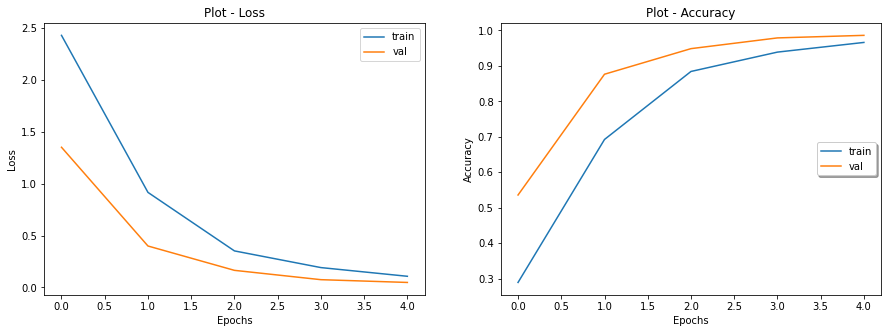

In [22]:
_, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(train_loss_list, label="train")
axs[0].plot(val_loss_list, label="val")
axs[0].set_title("Plot - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right', shadow=False)

# Accuracy plot
axs[1].plot(train_acc_list, label="train")
axs[1].plot(val_acc_list, label="val")
axs[1].set_title("Plot - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right', shadow=True)

In [23]:
MODEL_FOLDER = "."
if not os.path.isdir(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)
    
PATH_TO_MODEL = MODEL_FOLDER + "/classification.pth"
if os.path.exists(PATH_TO_MODEL):
    os.remove(PATH_TO_MODEL)
torch.save(model.state_dict(), PATH_TO_MODEL)

print("Model saved at %s" %(PATH_TO_MODEL))

Model saved at ./classification.pth
